In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal
from sklearn import preprocessing as p

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [43]:
def prior_unif():
  return tfd.Uniform(0,10)

In [44]:
def prior_out(a,b,g,k):
  a_prior = tfd.Uniform(0,10).prob(a)
  b_prior = tfd.Uniform(0,10).prob(b)
  g_prior = tfd.Uniform(0,10).prob(g)
  k_prior = tfd.Uniform(0,10).prob(k)
  return  a_prior *b_prior * g_prior*  k_prior 

In [45]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [46]:
def K_h(u,h):
  return my_kernel(u/h)/h

In [47]:
def S2(y):
  quantiles= np.zeros(9)
  for i in range(9):
      quantiles[i]= np.quantile(y,0.1+0.1*i)       #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [48]:
def S1(y):
  return np.mean(y)

In [49]:
from scipy.spatial import distance

def distance(s_old, s_obs):
   return np.linalg.norm(s_old-s_obs)
   # return distance.mahalanobis(s_old, s_obs, iv)

      

In [50]:
def quantile_fun(a,b,g,k,z):
    y = a+b*(1+0.8*(1-np.exp(-g*z))/(1+np.exp(-g*z)))*((1+z**2)**k)*z
    return y

In [51]:
##MAXIMAL COUPLING OF THETA
def maximal_coupling(x,y):
      current_x = x
      current_y = y  
      proposed_x = current_x + tfd.Normal(0,1).sample()
      pX = sstat.norm.pdf(proposed_x,current_x,1)
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.norm.pdf(proposed_x,current_y,1)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = current_y + tfd.Normal(0,1).sample()
                qY =  sstat.norm.pdf(proposed_y,current_y,1) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = sstat.norm.pdf(proposed_y,current_x,1)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]

In [60]:
def prob(H,s_obs,s_current,a_current,s_i,a_i):   #s[i,],a[i]
  NUM = (K_h(distance(np.array(s_current), np.array(s_obs)),H)*prior_unif().prob(a_current))
  DEN = (K_h(distance(np.array(s_i),np.array(s_obs)),H)* prior_unif().prob(a_i))
  return NUM/DEN    

In [61]:
def abc_algo_single_a (N, S, y_obs,h):
    s_obs = S(y_obs)
    s1 = np.zeros((N+1,9))
    s2 = np.zeros((N+1,9))
    y1 = np.zeros(n)
    y2 = np.zeros(n)
    y1_current = np.zeros(n)
    y2_current = np.zeros(n)
    a1 = np.zeros(N+1)
    a2 = np.zeros(N+1)
    k1=0
    k2=0
    a1_0 =prior_unif().sample(1)
    a2_0 =prior_unif().sample(1)
    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y1[i]=quantile_fun(a1_0,b_0,g_0,k_0,z)
    s1_0 = S(y1)

    for i in range(n):
      z = tfd.Normal(0,1).sample() 
      y2[i]=quantile_fun(a2_0,b_0,g_0,k_0,z)
    s2_0 = S(y2)
   
    H=h
    #while K_h(mahal(np.array(s_0),np.array(s_obs)),H)<=0:
    while K_h(distance(np.array(s1_0),np.array(s_obs)),H)<=0:    
        a1_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y1[j]=quantile_fun(a1_0,b_0,g_0,k_0,z)
        s1_0 = S(y1)
   
    a1[0]=a1_0

    while K_h(distance(np.array(s2_0),np.array(s_obs)),H)<=0:    
        a2_0 =prior_unif().sample()
        for j in range(n):
          z = tfd.Normal(0,1).sample()
          y2[j]=quantile_fun(a2_0,b_0,g_0,k_0,z)
        s2_0 = S(y2)
   
    a2[0]=a2_0
    

    for i in range(N):
        
        a1_current,a2_current = maximal_coupling(a1[i],a2[i])
        b_current = b_0
        g_current = g_0
        k_current = k_0      
        for j in range(n):
          z = tfd.Normal(0,1).sample() 
          y1_current[j] = quantile_fun(a1_current,b_current,g_current,k_current,z)
          y2_current[j] = quantile_fun(a2_current,b_current,g_current,k_current,z)
        s1_current = S(y1_current)
        s2_current = S(y2_current)

       
        #den_num=tfd.Normal(theta_muold,1).prob(theta_mucurrent)*tfd.Normal(theta_tauold,1).prob(theta_taucurrent)
        #den_den=tfd.Normal(theta_mucurrent,1).prob(theta_muold)*tfd.Normal(theta_taucurrent,1).prob(theta_tauold)
        
        prob1 = prob(H,s_obs,s1_current,a1_current,s1[i,],a1[i])   #s[i,],a[i]unif().prob(a[i]))
        prob2 = prob(H,s_obs,s2_current,a2_current,s2[i,],a2[i])

        acc_prob1 = min([1.,prob1])
        acc_prob2 = min([1.,prob2])
      
        u = tfd.Uniform(0,1).sample()
        if u < acc_prob1:
              a1[i+1] = a1_current
              s1[i+1,] = s1_current
              k1+=1
        else: 
              a1[i+1] = a1[i]
              s1[i+1,] = s1[i,]

        if u < acc_prob2:
              a2[i+1] = a2_current
              s2[i+1,] = s2_current
              k2+=1
        else: 
              a2[i+1] = a2[i]
              s2[i+1,] = s2[i,]

        
    return a1,a2,k1,k2

In [54]:
aobs = 3
bobs = 1
gobs = 2
kobs = 0.5
n = 100
h = 0.6
y_obs = np.zeros(n)
for i in range(n):
  z = tfd.Normal(0,1).sample() 
  y_obs[i] = quantile_fun(aobs,bobs,gobs,kobs,z)

In [55]:
g_0 =2
b_0 =1
k_0=0.5

In [62]:
a1_post,a2_post,acc1,acc2 = abc_algo_single_a (500, S2, y_obs, h)  

In [63]:
np.mean(a1_post)

3.0901032273997804

In [64]:
np.mean(a2_post)

3.3538434571380207

In [65]:
acc1

104

In [66]:
acc2

100

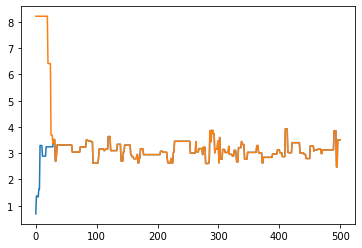

In [67]:
a_post = []
for i in range(len(a1_post)):
  a_post.append([a1_post[i],a2_post[i]])
plt.plot(a_post)

(array([  1.,   1.,   5.,   0.,   0.,  25., 110., 220., 120.,  19.]),
 array([0.6865949 , 1.01062751, 1.33466011, 1.65869272, 1.98272532,
        2.30675793, 2.63079054, 2.95482314, 3.27885575, 3.60288835,
        3.92692096]),
 <a list of 10 Patch objects>)

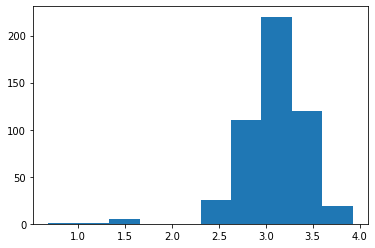

In [69]:
plt.hist(a1_post)